### Gas flood
#### Zach Murphy, 7-25-2022

In [1]:
#imports
import numpy as np
import math as m
import pandas as pd
import matplotlib.pyplot as plt
import gas_density as rho_g_fun # Temp IN C and Pressure in PSI
%matplotlib inline

In [2]:
# IMPORT DATA
df=pd.read_excel('ST140_gas.xlsx')
df2=pd.read_excel('GC_results.xlsx')
#Calculate gas values (e.g. 1 PV=4.96 ls  at ST140 conditions)
df['P avg']=(df['P up']+df['P down'])/2
df['Gas out']=df['Gas out']*1.1
df['PV in']=df['Gas in']/4.96
df['PV out']=df['Gas out']/4.96

In [4]:
# Density
df['rho_g_m'],df['Z']=rho_g_fun.CH4_EOS(df['T'],df['P down']) #density (mol/m3) and Z
rho_h=912*1000/124+(912*1000/124)*5.75 #density of hydrate (mol/m^3)
rho_l=1027.6*1000/18.02 #(mol/m^3)  #1027.6 #kg/m^3 # !ASSUME TO BE CONSTANT BUT CAN ADD FUCTION TO UPDATE!

In [6]:
# Core Parameters
L=7.62 #sample length (m)
r=0.00493/2 #sample radius (m)
A=m.pi*r**2 #sample area (m^2)
V_sample=A*L #sample volume (m^3)
por=.39 #sample porosity (-)
Vp=V_sample*por #sample pore volume (m^3)
Vp_ml=Vp*10**6
V_line=5 #volume of lines, fittings, etc
R=8.314 #gas constants (Pa m^3)/(mol k)
#BPR=825 #BPR set pressure

In [8]:
# Known Constants
Xwg=0; Xmg=1 #mass fractions in gas phase (gas is pure methane) 
Xmh=0.17; Xwh=0.83  #mol fractions in hydrate phase
Xml=0.0007; Xwl=1-Xml

In [9]:
# Initial Conditions
Sli=0.75 #intial liquid saturation
Sgi=0.0 # initial gas saturation
Shi=0.25 #initial hydrate saturation

In [10]:
#  Initial Moles
mWi=(Xwl*Sli*rho_l+Xwh*Shi*rho_h)*Vp #mols of h2o
mGi=(Xml*Sli*rho_l+Xmg*Sgi*df['rho_g_m'][0]+Xmh*Shi*rho_h)*Vp #mols of ch4

In [11]:
# mol in and mol out each time step
df['mGas in']=(df['Gas in']*0.000001)*df['rho_g_m'] #ml at reservoir conditions to mol gas
df['mGas out']=(df['Gas out']*0.000001)*df['rho_g_m'] #mol gas out

df['mWater in']=df['Water in']*.000001*rho_l*Xwl #mol water in
df['mWater out']=df['Water out']*.000001*rho_l*Xwl #mol water out

df['deltamG']=df['mGas in'].diff()-df['mGas out'].diff() #change in mass of gas in system (kg)
df['deltamW']=df['mWater in'].diff()-df['mWater out'].diff() #change in mass of water in system (kg)

df=df.fillna(0)

df['mGAS']=mGi+df['deltamG'].cumsum() #mol of gas
df['mH2O']=mWi+df['deltamW'].cumsum() #mol of water

In [12]:
# Matrix to solve for Saturation
sat=pd.DataFrame(columns=['time','Sl','Sg','Sh'])
for i,row in df.iterrows():
    A=np.array([[1, 1, 1],
                [Xwl*rho_l, Xwg*df['rho_g_m'][i],Xwh*rho_h],
                [Xml*rho_l, Xmg*df['rho_g_m'][i], Xmh*rho_h]]) 
   
    B=np.array([1,df['mH2O'][i]/Vp,df['mGAS'][i]/Vp])
    X=np.linalg.solve(A,B)
    
    sat=sat.append({'Sh':X[2],'Sg':X[1],'Sl':X[0],'time':df['time'][i]},ignore_index=True)

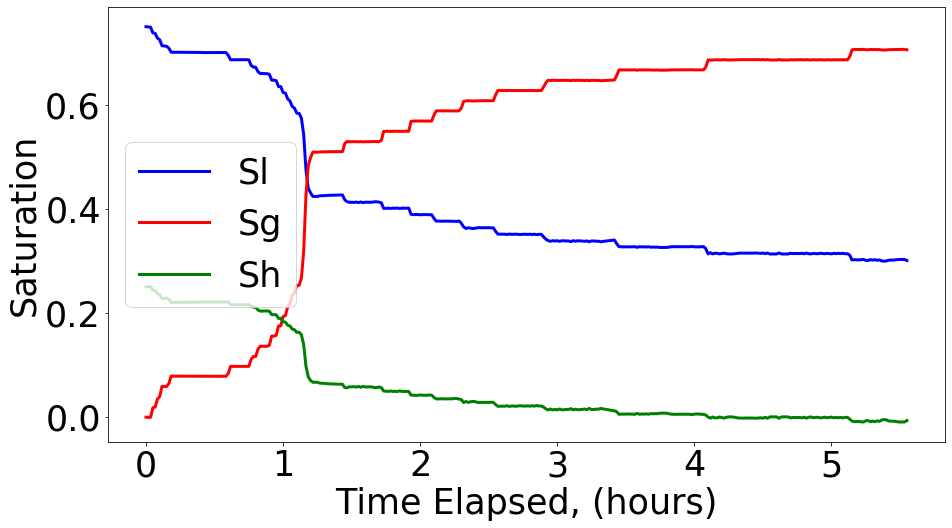

In [14]:
# Saturation vs Time
plt.figure(figsize=(15,8))
plt.rcParams['font.size']=35

plt.plot(sat['time'],sat['Sl'],label='Sl',linewidth=3,color='blue')
plt.plot(sat['time'],sat['Sg'],label='Sg',linewidth=3,color='red')
plt.plot(sat['time'],sat['Sh'],label='Sh',linewidth=3,color='green')
#plt.plot(sat['time'],sat['Sh']+sat['Sl']+sat['Sg'],label='sum',linewidth=3,color='black')


plt.xlabel('Time Elapsed, (hours)')
#plt.xlim([0,5])

#plt.ylim([0,1])
plt.ylabel('Saturation')
plt.legend(loc='best')

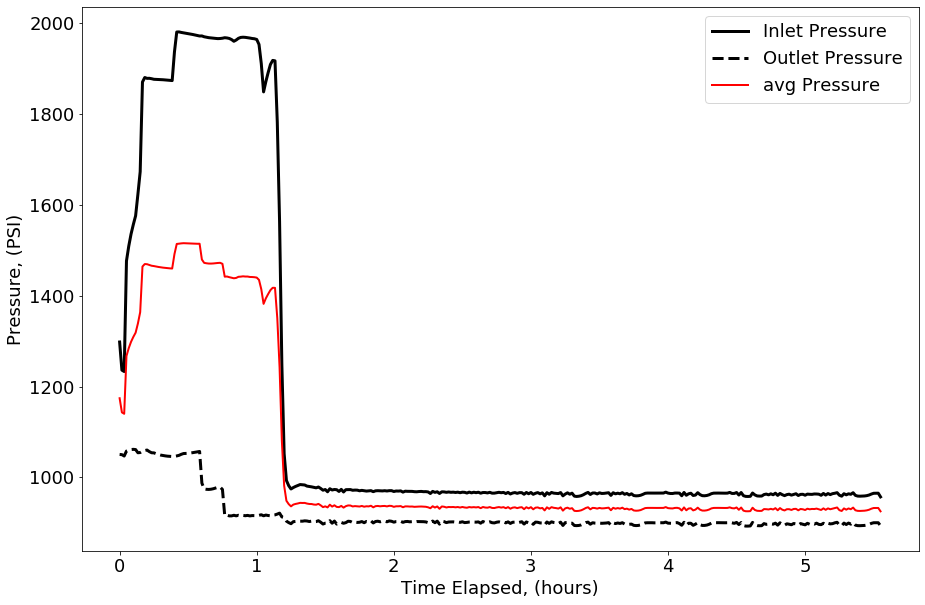

In [15]:
fig=plt.figure(figsize=(15,10))
plt.rcParams['font.size']=18
sharex='True'

plt1=fig.add_subplot(1,1,1)
plt1.plot(df['time'],df['P up'],label='Inlet Pressure',linewidth=3,color='black')
plt1.plot(df['time'],df['P down'],label='Outlet Pressure',linewidth=3,color='black',linestyle='dashed')
#plt1.plot(df['time'],df['P Pump'],label='Pump Pressure',linewidth=2,color='blue')
plt1.plot(df['time'],df['P avg'],label='avg Pressure',linewidth=2,color='red')
#plt.xlim([68,74])
plt.xlabel('Time Elapsed, (hours)')
#plt.ylim([900,1400])
plt.ylabel('Pressure, (PSI)')
plt.legend(loc='best')

#plt2=fig.add_subplot(2,1,2,sharex=plt1)
#plt2.plot(df['time'],df['Water in'],label='Gas In',linewidth=3,color='black')
#plt2.plot(df['time'],df['Water out'],label='Gas Out',linewidth=3,color='black',linestyle='dashed')
#plt.xlim([800,1005])
#plt.xlabel('Time Elapsed, (hours)')
#plt.ylim([900,1400])
#plt.ylabel('Volume, (mL @ reservoir conditions)')
#plt.legend(loc='best')
#plt.title(' Gas in * 0.82', y=.9)

plt.legend(loc='best')

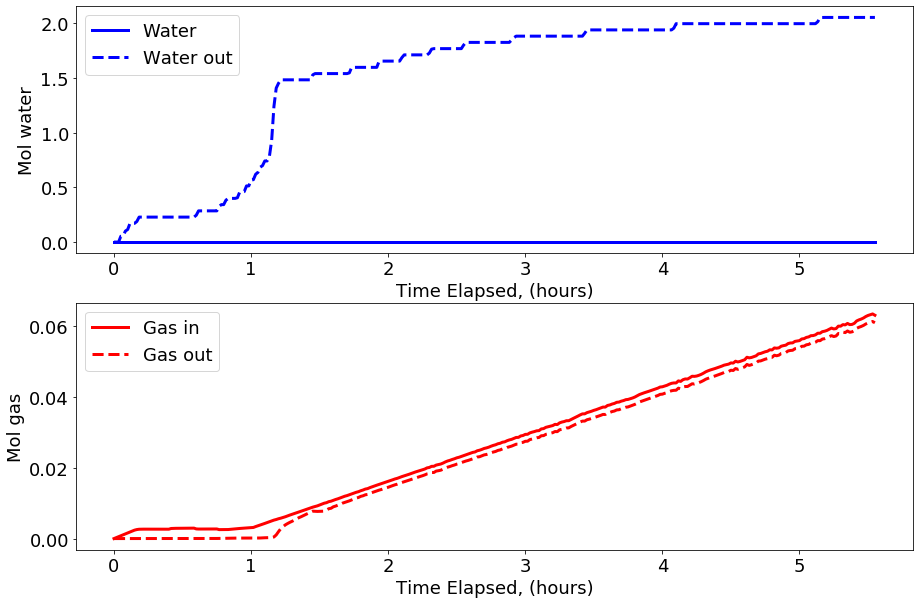

In [17]:
# Mol vs Time
fig=plt.figure(figsize=(15,10))
plt.rcParams['font.size']=18

plt1=fig.add_subplot(2,1,1)
plt1.plot(df['time'],df['mWater in'],label='Water',linewidth=3,color='blue')
plt1.plot(df['time'],df['mWater out'],label='Water out',linewidth=3,color='blue',linestyle='dashed')

plt.xlabel('Time Elapsed, (hours)')
#plt.xlim([0,5])
#plt.ylim([-.5,1])
plt.ylabel('Mol water')
plt.legend(loc='best')

plt2=fig.add_subplot(2,1,2)
plt2.plot(df['time'],df['mGas in'],label='Gas in',linewidth=3,color='red')
plt2.plot(df['time'],df['mGas out'],label='Gas out',linewidth=3,color='red',linestyle='dashed')

plt.xlabel('Time Elapsed, (hours)')
#plt.xlim([0,10])
#plt.ylim([0,3])
plt.ylabel('Mol gas')
plt.legend(loc='best')

In [18]:
# MOL of each gas at each time step
df['mCH4 in']=df['mGas in']*0
df['mCH4 out']=(df['mGas out'].diff()*df['%CH4 out']).cumsum()

df['mN2 in']=df['mGas in']*.8
df['mN2 out']=(df['mGas out'].diff()*df['%N2 out']).cumsum()

df['mCO2 in']=df['mGas in']*.2
df['mCO2 out']=(df['mGas out'].diff()*df['%CO2 out']).cumsum()

df['deltamW']=df['mWater in'].diff()-df['mWater out'].diff() #change in mol of water in system
df=df.fillna(0)

df['mCH4']=mGi+df['mCH4 in']-df['mCH4 out']
df['mN2']=df['mN2 in']-df['mN2 out']
df['mCO2']=df['mCO2 in']-df['mCO2 out']

#mol% of each component
df=df.fillna(0)
df['mol_total']=(df['mCH4']+df['mN2']+df['mCO2']+df['mH2O'])

df['mol%CH4']=df['mCH4']/df['mol_total']
df['mol%N2']=df['mN2']/df['mol_total']
df['mol%CO2']=df['mCO2']/df['mol_total']
df['mol%H2O']=df['mH2O']/df['mol_total']

Text(0.5, 0, 'Time Elapsed, (hours)')

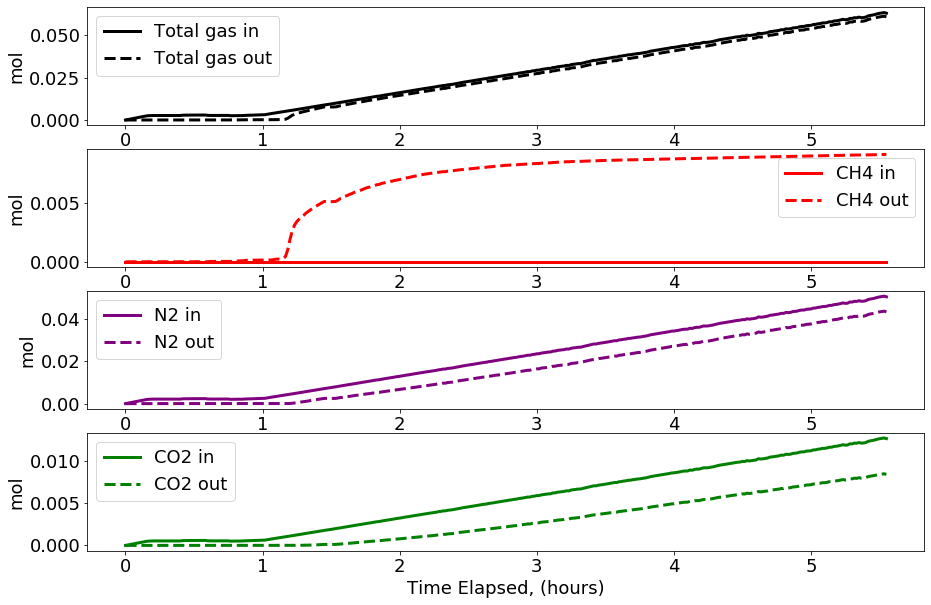

In [19]:
# Gas in/out vs Time
fig=plt.figure(figsize=(15,10))
plt.rcParams['font.size']=18

plt4=fig.add_subplot(4,1,1)
plt4.plot(df['time'],df['mGas in'],label='Total gas in',linewidth=3,color='black')
plt4.plot(df['time'],df['mGas out'],label='Total gas out',linewidth=3,color='black',linestyle='dashed')
#plt4.plot(df['time'],df['mH2O'],label='water out',linewidth=3,color='blue',linestyle='dashed')
plt.ylabel('mol')
plt.legend(loc='best')

plt1=fig.add_subplot(4,1,2)
plt1.plot(df['time'],df['mCH4 in'],label='CH4 in',linewidth=3,color='red')
plt1.plot(df['time'],df['mCH4 out'],label='CH4 out',linewidth=3,color='red',linestyle='dashed')
plt.ylabel('mol')
plt.legend(loc='best')

plt2=fig.add_subplot(4,1,3)
plt2.plot(df['time'],df['mN2 in'],label='N2 in',linewidth=3,color='purple')
plt2.plot(df['time'],df['mN2 out'],label='N2 out',linewidth=3,color='purple',linestyle='dashed')
plt.ylabel('mol')
plt.legend(loc='best')

plt3=fig.add_subplot(4,1,4)
plt3.plot(df['time'],df['mCO2 in'],label='CO2 in',linewidth=3,color='green')
plt3.plot(df['time'],df['mCO2 out'],label='CO2 out',linewidth=3,color='green',linestyle='dashed')

plt.ylabel('mol')
plt.legend(loc='best')
plt.xlabel('Time Elapsed, (hours)')

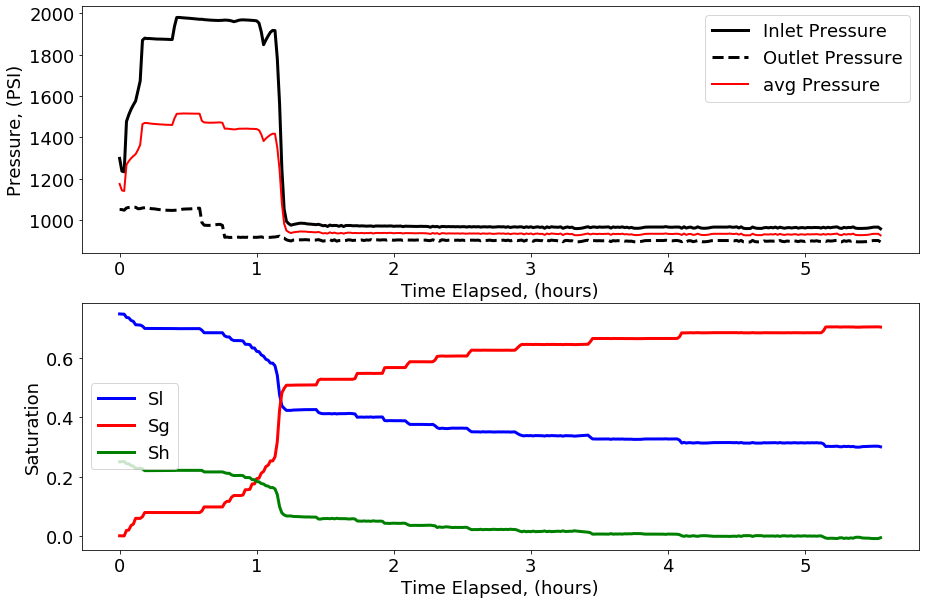

In [20]:
fig=plt.figure(figsize=(15,10))
plt.rcParams['font.size']=18
sharex='True'

plt1=fig.add_subplot(2,1,1)
plt1.plot(df['time'],df['P up'],label='Inlet Pressure',linewidth=3,color='black')
plt1.plot(df['time'],df['P down'],label='Outlet Pressure',linewidth=3,color='black',linestyle='dashed')
plt1.plot(df['time'],df['P avg'],label='avg Pressure',linewidth=2,color='red')
#plt1.axhline(BPR,0,1000,label='BPR Pressure',linewidth=2,color='green')
#plt.xlim([800,1005])
plt.xlabel('Time Elapsed, (hours)')
#plt.ylim([900,1400])
plt.ylabel('Pressure, (PSI)')
plt.legend(loc='best')

plt2=fig.add_subplot(2,1,2,sharex=plt1)
plt2.plot(sat['time'],sat['Sl'],label='Sl',linewidth=3,color='blue')
plt2.plot(sat['time'],sat['Sg'],label='Sg',linewidth=3,color='red')
plt2.plot(sat['time'],sat['Sh'],label='Sh',linewidth=3,color='green')
#plt.ylim([-1,1.5])

plt.xlabel('Time Elapsed, (hours)')

plt.ylabel('Saturation')
plt.legend(loc='best')

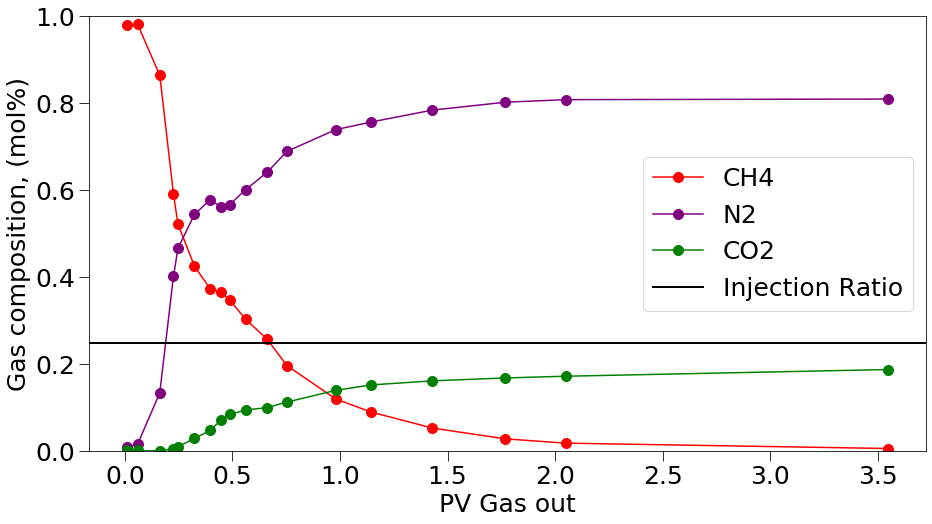

In [22]:
fig=plt.figure(figsize=(15,8))
plt.rcParams['font.size']=25

plt.plot(df2['PV out'],df2['CH4'],'-o',markersize=10,color='red',label='CH4')
plt.plot(df2['PV out'],df2['N2'],'-o',markersize=10,color='purple',label='N2')
plt.plot(df2['PV out'],df2['CO2'],'-o',markersize=10,color='green',label='CO2')

plt.axhline(.25,0,25,label='Injection Ratio',linewidth=2,color='black')
#plt.plot(df2['PV out'],df2['%CO2']/df2['%N2'],':',color='black',label='Effluent Ratio')

#plt.xlim([0,1.4])
plt.xlabel('PV Gas out')
#plt.xticks([0,0.2,0.4,0.6,0.8,1.0,1.2])

plt.ylim([0,1])
plt.ylabel('Gas composition, (mol%)')
#plt.yticks([0,0.20,0.40,0.60,0.80,1.00])
plt.tick_params(axis='both',length=10.0)

plt.legend(loc='best');

In [23]:
df3=pd.read_excel('CO2_CH4_Simulation.xlsx')
df['N2 injected']=0.8
df['CO2 injected']=0.2

CH4i=.6
df['deltaCH4 in']=0
df['deltaCH4 out']=df['%CH4 out']*df['PV out'].diff()
df['CH4 in PV']=df['deltaCH4 in'].cumsum()
df['CH4 out PV']=df['deltaCH4 out'].cumsum()
df['CH4 in core']=CH4i+df['CH4 in PV']-df['CH4 out PV']

df['deltaN2 in']=.8*df['PV in'].diff()
df['deltaN2 out']=df['%N2 out']*df['PV out'].diff()
df['N2 in PV']=df['deltaN2 in'].cumsum()
df['N2 out PV']=df['deltaN2 out'].cumsum()
df['N2 in core']=df['N2 in PV']-df['N2 out PV']

df['deltaCO2 in']=.2*df['PV in'].diff()
df['deltaCO2 out']=df['%CO2 out']*df['PV out'].diff()
df['CO2 in PV']=df['deltaCO2 in'].cumsum()
df['CO2 out PV']=df['deltaCO2 out'].cumsum()
df['CO2 in core']=df['CO2 in PV']-df['CO2 out PV']

Text(0.5, 0, 'Time Elapsed, (hours)')

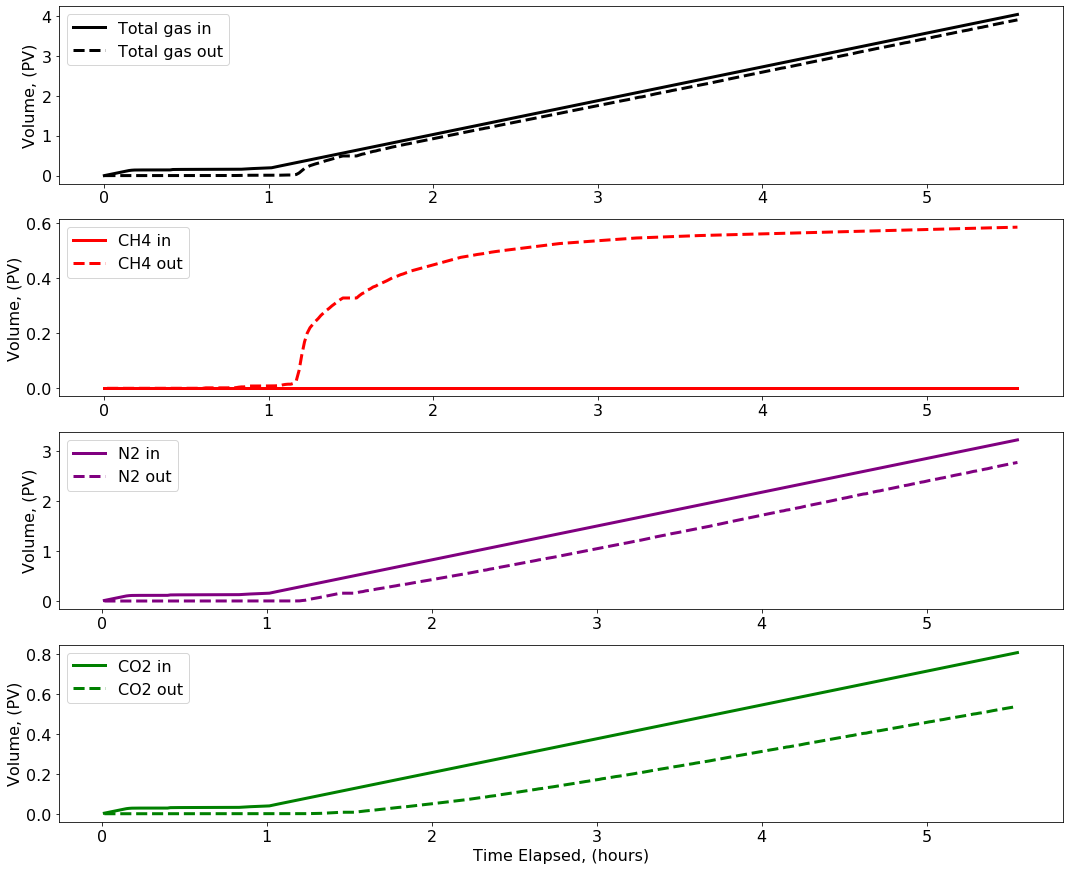

In [24]:
# Gas in/out vs Time
fig=plt.figure(figsize=(18,15))
plt.rcParams['font.size']=16

plt4=fig.add_subplot(4,1,1)
plt4.plot(df['time'],df['PV in'],label='Total gas in',linewidth=3,color='black')
plt4.plot(df['time'],df['PV out'],label='Total gas out',linewidth=3,color='black',linestyle='dashed')
plt.ylabel('Volume, (PV)')
plt.legend(loc='best')

plt1=fig.add_subplot(4,1,2)
plt1.plot(df['time'],df['CH4 in PV'],label='CH4 in',linewidth=3,color='red')
plt1.plot(df['time'],df['CH4 out PV'],label='CH4 out',linewidth=3,color='red',linestyle='dashed')
plt.ylabel('Volume, (PV)')
plt.legend(loc='best')

plt2=fig.add_subplot(4,1,3)
plt2.plot(df['time'],df['N2 in PV'],label='N2 in',linewidth=3,color='purple')
plt2.plot(df['time'],df['N2 out PV'],label='N2 out',linewidth=3,color='purple',linestyle='dashed')
plt.ylabel('Volume, (PV)')
plt.legend(loc='best')

plt3=fig.add_subplot(4,1,4)
plt3.plot(df['time'],df['CO2 in PV'],label='CO2 in',linewidth=3,color='green')
plt3.plot(df['time'],df['CO2 out PV'],label='CO2 out',linewidth=3,color='green',linestyle='dashed')
plt.ylabel('Volume, (PV)')
plt.legend(loc='best')
plt.xlabel('Time Elapsed, (hours)')

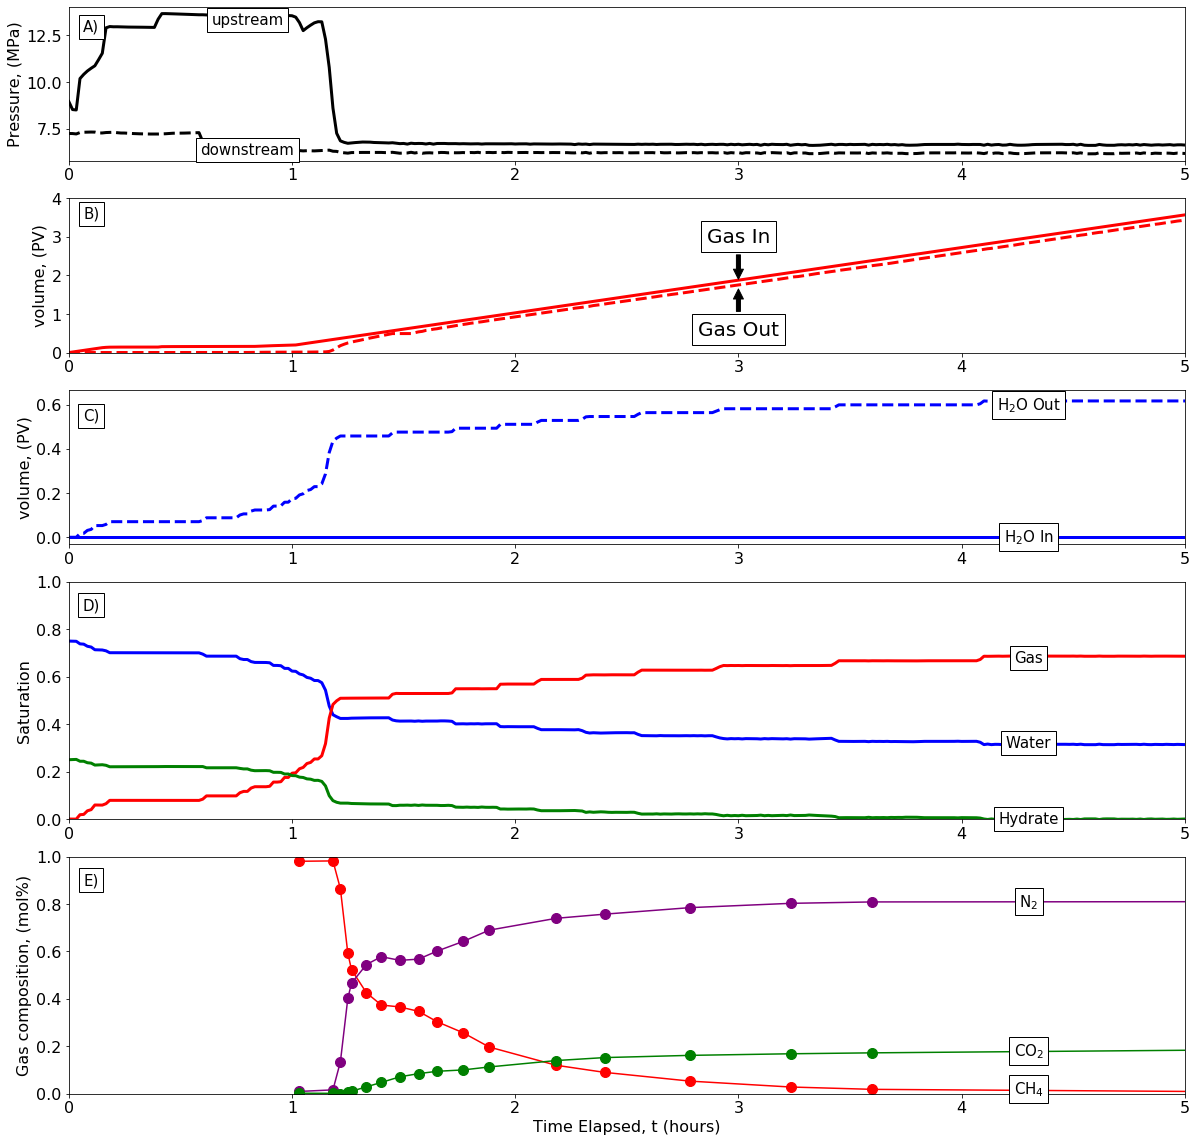

In [28]:
from matplotlib import gridspec

f = plt.figure(figsize=(20,20)) 
gs = gridspec.GridSpec(5, 1, height_ratios=[1.3,1.3,1.3,2,2])


sharex='True'
ax0 = plt.subplot(gs[0])
ax0.plot(df['time'],df['P up']*0.00689476,label='Inlet Pressure',linewidth=3,color='black')
ax0.plot(df['time'],df['P down']*0.00689476,label='Outlet Pressure',linewidth=3,color='black',linestyle='dashed')
#ax0.plot(df['time'],df['P avg'],label='avg Pressure',linewidth=2,color='red',linestyle='dotted')
plt.xlim([0,5])
#plt.xlabel('Time Elapsed, (hours)')
#plt.ylim([0,4])
plt.ylabel('Pressure, (MPa)')

#ax0.annotate("Hydrate (25%)", xy=(1, 1500), xycoords="data",va="center",ha="center",size=25,bbox=dict(boxstyle="square", fc="w"))

ax0.annotate("upstream",xy=(.8, 1930*0.00689476), xycoords='data',
                  size=15, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),)

ax0.annotate("downstream",xy=(.8,920*0.00689476), xycoords='data',
                  size=15, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),)

ax0.annotate("A)",xy=(0.1, 12.95), xycoords='data',
                  size=15, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),)

ax1 = plt.subplot(gs[1],sharex=ax0)
ax1.plot(df['time'],df['Gas in']/4.96,label='Gas in',linewidth=3,color='red')
ax1.plot(df['time'],df['Gas out']/4.96,label='Gas out',linewidth=3,color='red',linestyle='dashed')
plt.ylabel('volume, (PV)')
plt.ylim([0,4])

ax1.annotate("Gas In",xy=(3, 1.85), xycoords='data',
                  xytext=(3, 3), textcoords='data',
                  size=20, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),
                  arrowprops=dict(arrowstyle="simple",fc="k"),)

ax1.annotate("Gas Out",xy=(3, 1.7), xycoords='data',
                  xytext=(3, 0.6), textcoords='data',
                  size=20, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),
                  arrowprops=dict(arrowstyle="simple",fc="k"),)
ax1.annotate("B)",xy=(0.1, 3.6), xycoords='data',
                  size=15, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),)

ax4 = plt.subplot(gs[2],sharex=ax0)
ax4.plot(df['time'],df['Water out']/Vp_ml,label='Water out',linewidth=3,color='blue',linestyle='dashed')
ax4.plot(df['time'],df['Water in']/Vp_ml,label='Water in',linewidth=3,color='blue')


ax4.annotate("H$_2$O In",xy=(4.3, 0), xycoords='data',
                  size=15, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),)

ax4.annotate("H$_2$O Out",xy=(4.3, .6), xycoords='data',
                  size=15, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),)
ax4.annotate("C)",xy=(0.1, .55), xycoords='data',
                  size=15, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),)

plt.ylabel('volume, (PV)')


ax2 = plt.subplot(gs[3],sharex=ax0)
ax2.plot(sat['time'],sat['Sl'],label='Sl',linewidth=3,color='blue')
ax2.plot(sat['time'],sat['Sg'],label='Sg',linewidth=3,color='red')
ax2.plot(sat['time'],sat['Sh'],label='Sh',linewidth=3,color='green')
plt.ylim([0,1])
plt.ylabel('Saturation')

ax2.annotate("Gas",xy=(4.3, 0.68), xycoords='data',
                  size=15, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),)

ax2.annotate("Water",xy=(4.3, .32), xycoords='data',
                  size=15, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),)

ax2.annotate("Hydrate",xy=(4.3, 0), xycoords='data',
                  size=15, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),)
ax2.annotate("D)",xy=(0.1, .9), xycoords='data',
                  size=15, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),)



ax3 = plt.subplot(gs[4],sharex=ax0)
ax3.plot(df2['Time Elapsed'],df2['CH4'],'-o',markersize=10,color='red',label='CH4')
ax3.plot(df2['Time Elapsed'],df2['N2'],'-o',markersize=10,color='purple',label='N2')
ax3.plot(df2['Time Elapsed'],df2['CO2'],'-o',markersize=10,color='green',label='CO2')

ax3.annotate("E)",xy=(0.1, .9), xycoords='data',
                  size=15, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),)

ax3.annotate("N$_2$",xy=(4.3, 0.81), xycoords='data',
                  size=15, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),)

ax3.annotate("CO$_2$",xy=(4.3, 0.18), xycoords='data',
                  size=15, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),)

ax3.annotate("CH$_4$",xy=(4.3, 0.02), xycoords='data',
                  size=15, va="center", ha="center",
                  bbox=dict(boxstyle="square", fc="w"),)
plt.xlabel('Time Elapsed, t (hours)')

plt.ylim([0,1])
plt.ylabel('Gas composition, (mol%)');

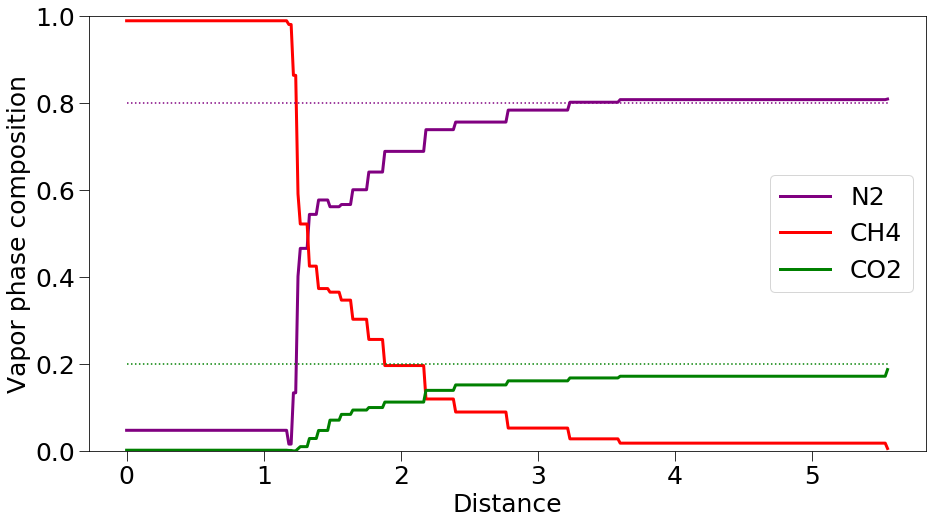

In [58]:
fig=plt.figure(figsize=(15,8))
plt.rcParams['font.size']=25

plt.plot(df['time'],df['%N2 out'],linewidth=3,color='purple',label='N2')
#plt.plot(df2['Time (pore volume)'],df2['X_N2'],'--',color='purple')

plt.plot(df['time'],df['%CH4 out'],linewidth=3,color='red',label='CH4')
#plt.plot(df2['Time (pore volume)'],df2['X_CH4'],'--',color='red')

plt.plot(df['time'],df['%CO2 out'],linewidth=3,color='green',label='CO2')
#plt.plot(df2['Time (pore volume)'],df2['X_CO2'],'--',color='green')

plt.plot(df['time'],df['N2 injected'],':',color='purple')
plt.plot(df['time'],df['CO2 injected'],':',color='green')

#plt.axhline(.25,0,25,label='Injection Ratio',linewidth=2,color='black')
#plt.plot(df['Gas out PV'],df['%CO2']/df['%N2'],':',color='black',label='Effluent Ratio')


#plt.xlim([0,2])
plt.xlabel('Distance')
#plt.xticks([0,0.2,0.4,0.6,0.8,1.0,1.2])

plt.ylim([0,1])
plt.ylabel('Vapor phase composition')
plt.yticks([0,0.20,0.40,0.60,0.80,1.00])
plt.tick_params(axis='both',length=10.0)

plt.legend(loc='best');

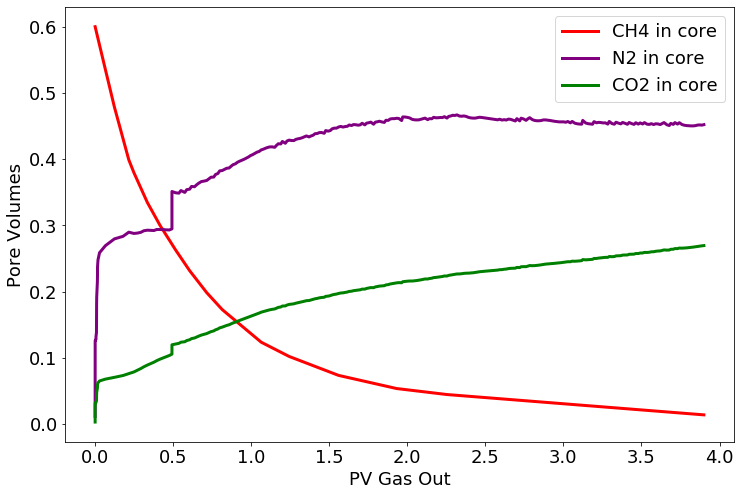

In [64]:
# Gas in/out vs Time
fig=plt.figure(figsize=(12,8))
plt.rcParams['font.size']=18

plt.plot(df['PV out'],df['CH4 in core'],label='CH4 in core',linewidth=3,color='red')
plt.plot(df['PV out'],df['N2 in core'],label='N2 in core',linewidth=3,color='purple')
plt.plot(df['PV out'],df['CO2 in core'],label='CO2 in core',linewidth=3,color='green')
#plt.plot(df['PV out'],df['CO2 in core']/(df['PV in']-df['PV out']),label='CO2/N2',linewidth=3,color='green')
#plt.plot(df['time'],Sli+Shi*Xwh+df['Water in']/Vp_ml-df['Water out']/Vp_ml,label='Water in core',linewidth=3,color='blue')

plt.ylabel('Pore Volumes')
plt.legend(loc='best')
plt.xlabel('PV Gas Out');